In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
#df = pd.read_csv('dataCompressed12_5_100.csv')
df = pd.read_csv('Data_Latest.csv')
#df = pd.read_csv('dataCompressed3_125_100.csv')
df.isna().sum()

x_0       0
x_1       0
target    0
dtype: int64

In [3]:
df.head()

,x_0,x_1,target
0,0.367913,-0.073622,0
1,0.156383,0.192457,0
2,-0.159244,0.634766,0
3,-0.438949,1.160518,0
4,-0.859950,1.773462,0


In [4]:
#df = df.drop('series_id', axis=1)
df.columns

Index(['x_0', 'x_1', 'target'], dtype='object')

In [5]:
features = list(df.columns)
features.remove("target")
features

['x_0', 'x_1']

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.head()

,x_0,x_1,target
0,0.290920,0.000202,0
1,0.285954,0.013256,0
2,0.278544,0.034957,0
3,0.271977,0.060752,0
4,0.262093,0.090825,0


In [7]:
import numpy as np
import pandas as pd
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(0, len(data) - seq_length, round(seq_length/2)):
        x = data[i:i+seq_length][['x_0', 'x_1']].values
        y0 = data.iloc[i]['target']
        y = data.iloc[i+seq_length]['target']
        #xs.append(x)
        #ys.append(y)
        if y0 == y:
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 20
#SEQ_LENGTH = 80
x_data, y_data = create_sequences(df, SEQ_LENGTH)
print(len(y_data))

4570


In [8]:
print(x_data[1])

[[0.17918508 0.22762767]
 [0.16319321 0.26584239]
 [0.15388617 0.28502561]
 [0.14123338 0.29913535]
 [0.13500601 0.32221037]
 [0.13082129 0.34166325]
 [0.12644748 0.36063132]
 [0.11384828 0.3809321 ]
 [0.10002552 0.39102044]
 [0.08313302 0.408815  ]
 [0.07288624 0.42878543]
 [0.07085692 0.44680737]
 [0.06550267 0.47606836]
 [0.05921826 0.51276524]
 [0.05448514 0.55745678]
 [0.04900091 0.59917058]
 [0.05248728 0.63575895]
 [0.06473372 0.65698329]
 [0.07811452 0.6836644 ]
 [0.09100714 0.71022983]]


In [9]:
type(x_data)

numpy.ndarray

In [10]:
# Placeholder lists for the final training and test sets
x_train_list, x_test_list = [], []
y_train_list, y_test_list = [], []
for label in df['target'].unique():
    x_data_class, y_data_class = create_sequences(df[df['target'] == label], SEQ_LENGTH)
    train_size = int(len(x_data_class) * 0.8)

    # Split the data for this class
    x_train_class, x_test_class = x_data_class[:train_size], x_data_class[train_size:]
    y_train_class, y_test_class = y_data_class[:train_size], y_data_class[train_size:]

    # Append to the final lists
    x_train_list.append(x_train_class)
    x_test_list.append(x_test_class)
    y_train_list.append(y_train_class)
    y_test_list.append(y_test_class)

# Concatenate data from all classes to get the final training and test sets
x_train = np.concatenate(x_train_list, axis=0)
x_test = np.concatenate(x_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [11]:
# For training data
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_labels_train, counts_train):
    print(f"Label {label} in training data: {count} instances")

print("\n")  # Just to separate the outputs

# For test data
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_labels_test, counts_test):
    print(f"Label {label} in test data: {count} instances")

Label 0.0 in training data: 365 instances
Label 1.0 in training data: 340 instances
Label 2.0 in training data: 285 instances
Label 3.0 in training data: 259 instances
Label 4.0 in training data: 416 instances
Label 5.0 in training data: 332 instances
Label 6.0 in training data: 384 instances
Label 7.0 in training data: 612 instances
Label 8.0 in training data: 366 instances
Label 9.0 in training data: 296 instances


Label 0.0 in test data: 92 instances
Label 1.0 in test data: 86 instances
Label 2.0 in test data: 72 instances
Label 3.0 in test data: 65 instances
Label 4.0 in test data: 105 instances
Label 5.0 in test data: 84 instances
Label 6.0 in test data: 96 instances
Label 7.0 in test data: 153 instances
Label 8.0 in test data: 92 instances
Label 9.0 in test data: 74 instances


In [12]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Flatten, Bidirectional

metrics = [SparseCategoricalAccuracy(name="accuracy")]

model = Sequential()
model.add(Bidirectional(LSTM(300, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 2))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\evenf\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [13]:
#!pip install keras-tuner

In [14]:
from tensorflow.python.client import device_lib
import tensorflow as tf
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [15]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_1', min_value=200, max_value=500, step=50),
        activation='relu',
        return_sequences=True,
        input_shape=(SEQ_LENGTH, 2)
    )))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_2', min_value=100, max_value=300, step=50),
        activation='relu',
        return_sequences=True
    )))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_3', min_value=50, max_value=200, step=50),
        activation='relu'
    )))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=100, max_value=300, step=50),
        activation='relu'
    ))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=metrics
    )
    return model

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # or however many trials you wish to run
    #directory='C:\\Users\\evenf\\OneDrive - Universitetet i Agder\\Even and Hamza PhD project work\\Human trajectory simulations paper\\LSTM Model with Dataset\\keras_tuner_dir'
)

tuner.search(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
csv_logger = CSVLogger('logs.csv', separator = ',', append = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, verbose=1)
def custom_lr_schedule(epoch):
    if epoch < 30:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (30 - epoch))
lr_scheduler = LearningRateScheduler(custom_lr_schedule, verbose=1)
lstm_history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=16, callbacks=[reduce_lr, lr_scheduler, csv_logger])

model.save('model_bilstm.keras')
np.save('history_bilstm.npy',lstm_history.history)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100


229/229 [==============================] - 23s 76ms/step - loss: 1.4177 - accuracy: 0.4389 - val_loss: 2.6036 - val_accuracy: 0.1643 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
229/229 [==============================] - 16s 69ms/step - loss: 0.9647 - accuracy: 0.6041 - val_loss: 2.5717 - val_accuracy: 0.1143 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
229/229 [==============================] - 16s 69ms/step - loss: 0.7445 - accuracy: 0.6848 - val_loss: 1.6075 - val_accuracy: 0.3297 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
229/229 [==============================] - 16s 69ms/step - loss: 0.6316 - accuracy: 0.7469 - val_loss: 0.6316 - val_accuracy: 0.7693 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
229/229 [==============================] - 16s 69ms/step - loss: 0.5356 - accuracy: 0.7770 - val_loss: 0.5684 - 

In [18]:
predictions = model.predict(x_test)
classes_x=np.argmax(predictions,axis=1)

print(x_test[1].shape)
print(predictions.shape)
print(classes_x)

29/29 [==============================] - 1s 22ms/step
(20, 2)
(919, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 4 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 7 1
 1 1 1 7 1 1 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 1 1 1 7 1 1 1 7 1 1 1 1 1 1 1 1
 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 8 2 2 2 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 1 4 4 4 4 7 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4
 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 1 4 4 4 4 4 4 4 4 4 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5

In [19]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=classes_x, num_classes=10)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 90,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  76,   0,   0,   5,   0,   0,   5,   0,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0,  65,   0,   0,   0,   0,   0,   0],
       [  0,   6,   0,   0,  98,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,  83,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   2,  88,   6,   0,   0],
       [  0,   0,   0,   0,   3,   1,  11, 138,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  92,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  74]])>

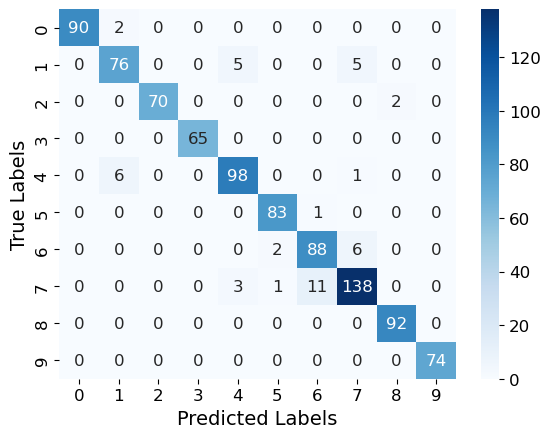

In [20]:
import matplotlib.pyplot as plt
font_style = {'family' : 'sans-serif', # 'Times New Roman'
        'weight' : 'normal',
        'size'   : 14}

font_style_nr = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

hm = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', annot_kws={'fontdict': font_style_nr})
hm.set_xticklabels(hm.get_xticklabels(), fontdict=font_style_nr)
hm.set_yticklabels(hm.get_yticklabels(), fontdict=font_style_nr)
cbar = hm.collections[0].colorbar
# Set font style for colorbar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('sans-serif')
    label.set_fontweight('normal')

plt.xlabel('Predicted Labels', fontdict=font_style)
plt.ylabel('True Labels', fontdict=font_style)
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        92
         1.0       0.90      0.88      0.89        86
         2.0       1.00      0.97      0.99        72
         3.0       1.00      1.00      1.00        65
         4.0       0.92      0.93      0.93       105
         5.0       0.97      0.99      0.98        84
         6.0       0.88      0.92      0.90        96
         7.0       0.92      0.90      0.91       153
         8.0       0.98      1.00      0.99        92
         9.0       1.00      1.00      1.00        74

    accuracy                           0.95       919
   macro avg       0.96      0.96      0.96       919
weighted avg       0.95      0.95      0.95       919

